# Import packages

In [ ]:
import finlab
# Read the API key from the text file
with open('credential.txt', 'r') as file:
    api_key = file.readline().strip()

# Use the API key to log in
finlab.login(api_key)

In [126]:
from finlab import data
import pandas as pd
import warnings
import requests

輸入成功!


In [127]:
import statsmodels.api as sm

In [128]:
import itertools

### Machine Learning

In [129]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [130]:
import tensorflow as tf
import keras

print(tf.__version__)  # 查看 TensorFlow 版本
print(keras.__version__)  # 查看 Keras 版本

2.15.0
2.15.0


In [131]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

In [132]:
from scikeras.wrappers import KerasRegressor, KerasClassifier
from sklearn.model_selection import GridSearchCV

In [133]:
from sklearn.metrics import mean_squared_error

### 圖像化

In [134]:
import matplotlib.pyplot as plt

# Functions

### Beta迴圈

In [135]:
def get_data_for_period(dataframe, start_year, end_year):
    df_copy = dataframe.copy()
    if df_copy.columns[1] != '發行量加權股價報酬指數':
        df_copy['收盤價(元)'] = df_copy['收盤價(元)'].pct_change()
    else:
        df_copy['發行量加權股價報酬指數'] = df_copy['發行量加權股價報酬指數'].pct_change()

    # 創建時間段
    start_date = f"{start_year}-01-01"
    end_date = f"{end_year}-12-31"

    # 確保日期列是日期的時間格式
    df_copy['Date'] = pd.to_datetime(df_copy['Date'])

    # 篩選出指定時間段內的數據
    filtered_data = df_copy[(df_copy['Date'] >= start_date) & (df_copy['Date'] <= end_date)]
    if df_copy.columns[1] != '發行量加權股價報酬指數':
        filtered_data = filtered_data[['Date', '收盤價(元)']]
    filtered_data = filtered_data.reset_index(drop=True)

    return filtered_data

### 依據時間切資料

In [136]:
def is_data_sufficient(dataframe, min_data_count):
    # return: 如果数据满足要求返回 True，否则返回 False。
    # 计算数据笔数
    data_count = len(dataframe)

    # 判断是否满足最小数据笔数要求
    return data_count >= min_data_count

### 篩選並踢除Beta值異常的股票。

In [137]:
def filter_extreme_betas(betas, threshold_factor=2):
    """
    :param betas: 一個包含股票代號和其Beta值的列表，格式為[(stock_code, beta), ...]。
    :param threshold_factor: 用於確定篩選閾值的倍數因子，預設為2。
    :return: 剔除異常Beta值的股票後的清單。
    """
    # 计算平均Beta值和标准差
    beta_values = [beta[1] for beta in betas]
    average_beta = sum(beta_values) / len(beta_values)
    std_dev_beta = (sum((x - average_beta) ** 2 for x in beta_values) / len(beta_values)) ** 0.5

    # 设定筛选阈值
    upper_threshold = average_beta + threshold_factor * std_dev_beta
    lower_threshold = average_beta - threshold_factor * std_dev_beta

    # 筛选并剔除异常Beta值的股票
    filtered_betas = [beta for beta in betas if lower_threshold <= beta[1] <= upper_threshold]

    return filtered_betas

### Cointegration test

In [138]:
def get_price_for_period(dataframe, start_year, end_year):
    df_copy = dataframe.copy()

    # 創建時間段
    start_date = f"{start_year}-01-01"
    end_date = f"{end_year}-12-31"

    # 確保日期列是日期的時間格式
    df_copy['Date'] = pd.to_datetime(df_copy['Date'])

    # 篩選出指定時間段內的數據
    filtered_data = df_copy[(df_copy['Date'] >= start_date) & (df_copy['Date'] <= end_date)]
    filtered_data = filtered_data['收盤價(元)']
    filtered_data = filtered_data.reset_index(drop=True)

    return filtered_data

### 定義協整測試函數

In [139]:
# 定义协整测试函数
def cointegration_test(stock1, stock2):
    # 确保两个DataFrame在日期上对齐
    stock1, stock2 = stock1.align(stock2, join='inner')

    # 提取价格数据
    # 假设每个DataFrame只包含一个列，代表股票价格
    # stock1_prices = stock1.iloc[:, 0]
    # stock2_prices = stock2.iloc[:, 0]

    # 进行线性回归
    model = sm.OLS(stock1, sm.add_constant(stock2)).fit()
    residuals = model.resid

    # 进行ADF检验
    adf_test = sm.tsa.adfuller(residuals)
    p_value = adf_test[1]

    return p_value

### Calculate spread

In [140]:
def calculate_spread(dataframe, stock_pair, start_year, end_year):
    # 提取两只股票的数据
    df_stock_1 = dataframe[dataframe['證券代碼'] == stock_pair[0]]
    df_stock_2 = dataframe[dataframe['證券代碼'] == stock_pair[1]]

    # 获取两只股票在指定时间段内的价格
    stock_1_prices = get_price_for_period(df_stock_1, start_year, end_year)
    stock_2_prices = get_price_for_period(df_stock_2, start_year, end_year)

    # print(stock_1_prices)
    # print(stock_2_prices)

    # 计算价差
    spread = stock_1_prices - stock_2_prices

    spread.dropna(inplace = True)

    return spread

### Calculate the profit

In [141]:
# if spread > 0, min_p_value_pair[0] > min_p_value_pair[1]
def get_overvalued_and_undervalued_stocks(dataframe, spread, stock_pair, year):
    # Calculate the spread
    spread = calculate_spread(dataframe, stock_pair, year, year)

    # Calculate the average spread over the year
    average_spread = spread.mean()

    if average_spread > 0:
        # stock_pair[0] is overvalued relative to stock_pair[1]
        overvalued_code = stock_pair[0]
        undervalued_code = stock_pair[1]
    else:
        # stock_pair[1] is overvalued relative to stock_pair[0]
        overvalued_code = stock_pair[1]
        undervalued_code = stock_pair[0]

    # Extract the prices for the overvalued and undervalued stocks
    df_overvalued = dataframe[dataframe['證券代碼'] == overvalued_code]
    df_undervalued = dataframe[dataframe['證券代碼'] == undervalued_code]
    prices_overvalued = get_price_for_period(df_overvalued, year, year)
    prices_undervalued = get_price_for_period(df_undervalued, year, year)

    return prices_overvalued, prices_undervalued, overvalued_code, undervalued_code

# 主程式碼

## 定義年份

In [142]:
const_year_start = 2009
const_year_test = const_year_start + 3

## 抓資料

In [143]:
close=data.get("price:收盤價")

# 取得 OHLC 直式格式

price = close.T.stack().reset_index()
price.columns = ["證券代碼", "Date", "收盤價(元)"]
open = data.get("price:開盤價").T.stack().reset_index()
open.columns = ["證券代碼", "Date", "開盤價(元)"]
price = price.merge(open, on = ["證券代碼", "Date"])
high = data.get("price:最高價").T.stack().reset_index()
high.columns = ["證券代碼", "Date", "最高價(元)"]
price = price.merge(high, on = ["證券代碼", "Date"])
low = data.get("price:最低價").T.stack().reset_index()
low.columns = ["證券代碼", "Date", "最低價(元)"]
price = price.merge(low, on = ["證券代碼", "Date"])

In [144]:
# 篩選出 4 位數字
price = price[price["證券代碼"].apply(lambda x: len(str(x)) == 4 and not str(x).startswith("00"))]
df = pd.DataFrame(price)
# df

In [145]:
TAIEX = data.get('benchmark_return:發行量加權股價報酬指數')

taiex = TAIEX.stack().reset_index()
taiex = taiex.drop(columns=['symbol'])
taiex.columns = ["Date", "發行量加權股價報酬指數"]
taiex = pd.DataFrame(taiex)
# taiex

### 把股票代碼存入list裡

In [146]:
stock_code_list = []

# 假设您的DataFrame名为df
# df = ...

# 创建一个空集合来存储股票代碼
stock_codes_set = set()

# 遍历DataFrame中的每一行
for code in df['證券代碼']:
    stock_codes_set.add(code)

# 将集合转换为列表
stock_code_list = list(sorted(stock_codes_set))

# 打印股票代碼列表和总数
# print("股票代碼列表:", stock_code_list)
print("不同的股票代碼总数:", len(stock_code_list))

不同的股票代碼总数: 2043


## 跑每三年的Beta迴圈

In [147]:
# # 使用示例
# # 假设taiex是您已有的DataFrame
# for year in range(const_year_start, 2023):
#     taiex_for_period = get_data_for_period(taiex, year, year + 2)
#     # print(taiex_for_period.head())

#     betas = {}
#     for stock_code in stock_code_list:
#         df_stock = df[df['證券代碼'] == stock_code]
#         stock_for_period = get_data_for_period(df_stock, year, year + 2)
#         if is_data_sufficient(stock_for_period , 700) == False:
#             continue
        
#         # print(stock_code)
#         # print('---------------')
#         # df_beta_calculate = pd.concat([stock_for_period, taiex_for_period], axis=1, join='inner')
#         # print(df_beta_calculate.head())
#         # df_beta_calculate.columns = ['stock_return', 'market_return']

#         df_beta_calculate = pd.DataFrame()
#         df_beta_calculate = pd.merge(stock_for_period, taiex_for_period, on='Date')

#         # X = df_beta_calculate['發行量加權股價報酬指數']
#         # y = df_beta_calculate['收盤價(元)']
#         # X = sm.add_constant(X)  # 添加常数项
#         # model = sm.OLS(y, X).fit()

#         covariance = df_beta_calculate['收盤價(元)'].cov(df_beta_calculate['發行量加權股價報酬指數'])
#         variance = df_beta_calculate['發行量加權股價報酬指數'].var()

#         # Beta系数是市场回报率的系数
#         # beta = model.params['發行量加權股價報酬指數']
#         betas[stock_code] = covariance / variance

#     #print(betas)
#     print(year)
#     break

In [148]:
# # Convert the dictionary to a DataFrame
# betas_df = pd.DataFrame(list(betas.items()), columns=['股票代碼', 'beta value'])

# # Save the DataFrame to an Excel file
# betas_df.to_excel('betas_2012.xlsx', index=False)

In [149]:
# Load the data from the Excel file
betas_from_excel = pd.read_excel('betas_2012.xlsx')

# Convert the DataFrame to a dictionary with '股票代碼' as keys and 'beta value' as values
# Convert stock codes to string to ensure the keys of the dictionary are strings
betas_dict = pd.Series(betas_from_excel['beta value'].values, 
                       index=betas_from_excel['股票代碼'].astype(str)).to_dict()

## 把股票分成aggressive pairs跟defensive pairs

In [150]:
aggressive_stocks = {stock: beta for stock, beta in betas_dict.items() if beta > 1}
top_10_aggressive_stocks = sorted(aggressive_stocks.items(), key=lambda x: x[1], reverse=True)[:15]
top_10_aggressive_stocks = filter_extreme_betas(top_10_aggressive_stocks)
# top_10_aggressive_stocks

In [151]:
defensive_stocks = {stock: beta for stock, beta in betas_dict.items() if beta < 1}
top_10_defensive_stocks = sorted(defensive_stocks.items(), key=lambda x: x[1], reverse=False)[:15]
top_10_defensive_stocks = filter_extreme_betas(top_10_defensive_stocks)
# top_10_defensive_stocks

## Cointegration test

In [152]:
# 假设 top_10_aggressive_stocks 是包含股票代码和Beta值的列表
stock_codes_a = [stock[0] for stock in top_10_aggressive_stocks]

# 生成所有可能的股票对
stock_pairs_a = list(itertools.combinations(stock_codes_a, 2))

In [153]:
# 對每對股票進行雙向協整測試並記錄 P 值
p_values_dict = {}

for pair in stock_pairs_a:
    stock1, stock2 = pair
    df_stock1 = df[df['證券代碼'] == stock1]
    df_stock2 = df[df['證券代碼'] == stock2]

    # 取得股票價格數據
    stock1_prices = get_price_for_period(df_stock1, const_year_start, const_year_start + 2)
    stock2_prices = get_price_for_period(df_stock2, const_year_start, const_year_start + 2)

    # 雙向協整測試
    p_value_1 = cointegration_test(stock1_prices, stock2_prices)
    p_value_2 = cointegration_test(stock2_prices, stock1_prices)

    # 如果兩個 P 值都小於 0.05，則記錄這對股票和它們的 P 值
    if p_value_1 < 0.05 and p_value_2 < 0.05:
        p_values_dict[(stock1, stock2)] = (p_value_1, p_value_2)

# 找出具有最小最大 P 值的股票对
min_p_value_pair = min(p_values_dict, key=lambda x: max(p_values_dict[x]))
min_p_values = p_values_dict[min_p_value_pair]

print(f"股票对 {min_p_value_pair} 有最小的 P 值: {min_p_values}")

股票对 ('6015', '6016') 有最小的 P 值: (0.0034585856125171114, 0.0023693276528996667)


## LSTM預測兩隻股票的spread

In [154]:
spread_train = calculate_spread(df , min_p_value_pair , const_year_start , const_year_start + 2)
# spread_train

In [155]:
# 规范化数据
scaler = MinMaxScaler(feature_range=(0, 1))
spread_train_scaled = scaler.fit_transform(spread_train.values.reshape(-1, 1))

In [156]:
X_train = []   #預測點的前 60 天的資料
y_train = []   #預測點
for i in range(60, len(spread_train)):  # 727 是訓練集總數，60代表用過去60天的資料訓練
    X_train.append(spread_train_scaled[i-60:i, 0])
    y_train.append(spread_train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)  # 轉成numpy array的格式，以利輸入 RNN

In [157]:
# Function to create the model, required for KerasClassifier
def create_model(units=50, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=units))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [158]:
# 初始化 LSTM 模型
model = Sequential()

In [159]:
# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

In [160]:
# Adding the output layer
model.add(Dense(units = 1))

In [161]:
# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error')

In [162]:
model.fit(X_train, y_train, epochs=150, batch_size=16)

Epoch 1/150
44/44 [==============================] - 18s 152ms/step - loss: 0.0392
Epoch 2/150
44/44 [==============================] - 6s 141ms/step - loss: 0.0173
Epoch 3/150
44/44 [==============================] - 7s 159ms/step - loss: 0.0156
Epoch 4/150
44/44 [==============================] - 5s 107ms/step - loss: 0.0154
Epoch 5/150
44/44 [==============================] - 5s 115ms/step - loss: 0.0135
Epoch 6/150
44/44 [==============================] - 5s 121ms/step - loss: 0.0146
Epoch 7/150
44/44 [==============================] - 6s 126ms/step - loss: 0.0139
Epoch 8/150
44/44 [==============================] - 6s 127ms/step - loss: 0.0119
Epoch 9/150
44/44 [==============================] - 5s 120ms/step - loss: 0.0123
Epoch 10/150
44/44 [==============================] - 5s 107ms/step - loss: 0.0109
Epoch 11/150
44/44 [==============================] - 6s 137ms/step - loss: 0.0151
Epoch 12/150
44/44 [==============================] - 6s 143ms/step - loss: 0.0111
Epoch 13/150

### 預測

In [163]:
spread_test = calculate_spread(df , min_p_value_pair , const_year_test, const_year_test)
real_stock_spread = spread_test.values

In [164]:
dataset_total = pd.concat((spread_train, spread_test), axis = 0) # dataset_total是真實的股價spread
inputs = dataset_total[len(dataset_total) - len(spread_test) - 60:].values # inputs是160筆真實的股價spread
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs) # Feature Scaling

In [165]:
X_test = []
for i in range(60, 60 + len(spread_test)): # timesteps一樣60； 160 = 先前的60天資料 + const_year_test年的244天資料
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))  # Reshape 成 3-dimension

In [166]:
predicted_stock_spread = model.predict(X_test)
predicted_stock_spread = scaler.inverse_transform(predicted_stock_spread)  # to get the original scale

8/8 [==============================] - 3s 36ms/step


### MSE

In [167]:
# Compute Mean Squared Error
mse = mean_squared_error(real_stock_spread, predicted_stock_spread)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.10844543086572937


In [168]:
# Convert the arrays to DataFrames
df_real_stock_spread_a = pd.DataFrame(real_stock_spread, columns=['Real Stock Spread'])
df_predicted_stock_spread_a = pd.DataFrame(predicted_stock_spread, columns=['Predicted Stock Spread'])

# Create DataFrames for stock codes and p-values
df_stock_codes_a = pd.DataFrame([[min_p_value_pair[0], min_p_value_pair[1]]], columns=['Stock Code 1', 'Stock Code 2'])
df_p_values_a = pd.DataFrame([[min_p_values[0], min_p_values[1]]], columns=['P-value 1', 'P-value 2'])

# Combine the DataFrames into a single DataFrame before saving
combined_df_a = pd.concat([df_real_stock_spread_a, df_predicted_stock_spread_a, df_stock_codes_a, df_p_values_a], axis=1)

# Save the combined DataFrame to an Excel file
combined_df_a.to_excel('aggressive_stock_data_2012.xlsx', index=False)

### 圖像化

Mean Squared Error: 4.31673002243042


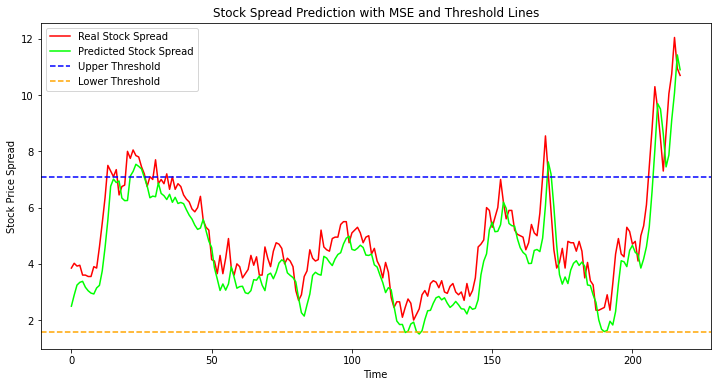

In [181]:
mean_spread = np.mean(predicted_stock_spread)
std_spread = np.std(predicted_stock_spread)
threshold = 1.5 * std_spread

# Visualising the results with MSE and threshold lines
plt.figure(figsize=(12,6))
plt.plot(real_stock_spread, color='red', label='Real Stock Spread')
plt.plot(predicted_stock_spread, color='lime', label='Predicted Stock Spread')

# Draw horizontal lines for the threshold
plt.axhline(y=mean_spread + threshold, color='blue', linestyle='--', label='Upper Threshold')
plt.axhline(y=mean_spread - threshold, color='orange', linestyle='--', label='Lower Threshold')

# Draw a horizontal line for MSE
# plt.axhline(y=mse, color='purple', linestyle='-', label=f'MSE: {mse:.4f}')

plt.title('Stock Spread Prediction with MSE and Threshold Lines')
plt.xlabel('Time')
plt.ylabel('Stock Price Spread')
plt.legend()
plt.show()

## Calculate the profit

In [170]:
# Assuming we have the same setup as previously defined
spreads = predicted_stock_spread  # Your spread data here

In [171]:
prices_overvalued, prices_undervalued, overvalued_code, undervalued_code = get_overvalued_and_undervalued_stocks(df, predicted_stock_spread, min_p_value_pair, const_year_test)
# print(len(prices_overvalued))
# print(prices_overvalued)
# print(prices_undervalued)

In [172]:
mean_spread = np.mean(spreads)
std_spread = np.std(spreads)
threshold = 1.5 * std_spread

# Track positions and other metrics
positions = []
profits = []
equity_curve = []
nominal_capital = 1  # Nominal capital at risk per trade
total_capital_invested = 0

total_shares_overvalued = 0
total_shares_undervalued = 0

for i, spread in enumerate(spreads):
    if (spread > mean_spread + threshold) or (spread < mean_spread - threshold):
        if i != len(spreads) - 1:
            # prices_overvalued, prices_undervalued, overvalued_code, undervalued_code = get_overvalued_and_undervalued_stocks(df, predicted_stock_spread, min_p_value_pair, const_year_test, i)
            # Enter trade
            num_shares_overvalued = nominal_capital / prices_overvalued[i] # 1 / prices_overvalued
            num_shares_undervalued = nominal_capital / prices_undervalued[i] # 1 / prices_undervalued
            if spread < 0:
                num_shares_overvalued = nominal_capital / prices_undervalued[i]
                num_shares_undervalued = nominal_capital / prices_overvalued[i]
            # debug
            print(f"Entering trade at index {i}, spread {spread}")
            print(f"Overvalued shares: {num_shares_overvalued}, Undervalued shares: {num_shares_undervalued}")
            total_shares_overvalued += num_shares_overvalued
            total_shares_undervalued += num_shares_undervalued
            total_capital_invested += (nominal_capital * 1.001425)
            positions.append(i)  # Store the index of the trading day
            check_enterOrNot = True
    if ((mean_spread - threshold <= spread <= mean_spread + threshold) and positions and check_enterOrNot == True) or (i == len(spreads) - 1 and positions and check_enterOrNot == True):
        # Exit trade
        exit_price_overvalued = prices_overvalued.iloc[-1]  # Last day price
        exit_price_undervalued = prices_undervalued.iloc[-1]  # Last day price
        pi = (total_shares_overvalued * exit_price_overvalued) - (total_shares_undervalued * exit_price_undervalued)
        pi = pi * (1 - 0.001425)
        profits.append(pi)
        positions.append(i)
        total_shares_overvalued = 0
        total_shares_undervalued = 0
        # debug
        print(f"Exiting trade at index {i}, spread {spread}")
        print(f"Profit from trade: {pi}")
        print("----------------END----------------")
        check_enterOrNot = False

        if i == len(spreads) - 1:  # If it's the last day, calculate the final equity curve point
            equity_curve.append(sum(profits) - total_capital_invested)


cumulative_profit = sum(profits)
total_trades = len(positions) # Total number of completed trades
total_capital_at_risk = total_trades * nominal_capital
return_rate = cumulative_profit / total_capital_at_risk if total_capital_at_risk != 0 else 0

print(f"Cumulative profit: {cumulative_profit}")
print(f"Total capital at risk: {total_capital_at_risk}")
print(f"Return rate: {return_rate * 100}%")

Entering trade at index 58, spread [-2.1253214]
Overvalued shares: 0.19157088122605365, Undervalued shares: 0.13986013986013984
Exiting trade at index 59, spread [-1.9057044]
Profit from trade: 0.1947359037992661
----------------END----------------
Cumulative profit: 0.1947359037992661
Total capital at risk: 2
Return rate: 9.736795189963306%


## Defensive Stocks

In [173]:
stock_codes_d = [stock[0] for stock in top_10_defensive_stocks]
# 生成所有可能的股票对
stock_pairs_d = list(itertools.combinations(stock_codes_d, 2))

# 對每對股票進行雙向協整測試並記錄 P 值
p_values_dict = {}

for pair in stock_pairs_d:
    stock1, stock2 = pair
    df_stock1 = df[df['證券代碼'] == stock1]
    df_stock2 = df[df['證券代碼'] == stock2]

    # 取得股票價格數據
    stock1_prices = get_price_for_period(df_stock1, const_year_start, const_year_start + 2)
    stock2_prices = get_price_for_period(df_stock2, const_year_start, const_year_start + 2)

    # 雙向協整測試
    p_value_1 = cointegration_test(stock1_prices, stock2_prices)
    p_value_2 = cointegration_test(stock2_prices, stock1_prices)

    # 如果兩個 P 值都小於 0.05，則記錄這對股票和它們的 P 值
    if p_value_1 < 0.05 and p_value_2 < 0.05:
        p_values_dict[(stock1, stock2)] = (p_value_1, p_value_2)

# 找出具有最小最大 P 值的股票对
min_p_value_pair = min(p_values_dict, key=lambda x: max(p_values_dict[x]))
min_p_values = p_values_dict[min_p_value_pair]

print(f"股票对 {min_p_value_pair} 有最小的最大 P 值: {min_p_values}")

股票对 ('3205', '8354') 有最小的最大 P 值: (0.00012167195533977332, 0.00010144495182136062)


In [174]:
spread_train = calculate_spread(df , min_p_value_pair , const_year_start , const_year_start + 2)

# 规范化数据
scaler = MinMaxScaler(feature_range=(0, 1))
spread_train_scaled = scaler.fit_transform(spread_train.values.reshape(-1, 1))

X_train = []   #預測點的前 60 天的資料
y_train = []   #預測點
for i in range(60, len(spread_train)):  # 727 是訓練集總數，60代表用過去60天的資料訓練
    X_train.append(spread_train_scaled[i-60:i, 0])
    y_train.append(spread_train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)  # 轉成numpy array的格式，以利輸入 RNN

# 初始化 LSTM 模型
model = Sequential()
# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error')

In [175]:
model.fit(X_train, y_train, epochs = 150, batch_size = 16)

Epoch 1/150
41/41 [==============================] - 16s 96ms/step - loss: 0.0332
Epoch 2/150
41/41 [==============================] - 4s 91ms/step - loss: 0.0163
Epoch 3/150
41/41 [==============================] - 4s 94ms/step - loss: 0.0144
Epoch 4/150
41/41 [==============================] - 4s 92ms/step - loss: 0.0139
Epoch 5/150
41/41 [==============================] - 4s 92ms/step - loss: 0.0126
Epoch 6/150
41/41 [==============================] - 4s 94ms/step - loss: 0.0113
Epoch 7/150
41/41 [==============================] - 4s 92ms/step - loss: 0.0104
Epoch 8/150
41/41 [==============================] - 4s 92ms/step - loss: 0.0100
Epoch 9/150
41/41 [==============================] - 4s 92ms/step - loss: 0.0100
Epoch 10/150
41/41 [==============================] - 4s 93ms/step - loss: 0.0093
Epoch 11/150
41/41 [==============================] - 4s 93ms/step - loss: 0.0090
Epoch 12/150
41/41 [==============================] - 4s 92ms/step - loss: 0.0081
Epoch 13/150
41/41 [====

In [176]:
spread_test = calculate_spread(df , min_p_value_pair , const_year_test, const_year_test)
real_stock_spread = spread_test.values

dataset_total = pd.concat((spread_train, spread_test), axis = 0) # dataset_total是真實的股價spread
inputs = dataset_total[len(dataset_total) - len(spread_test) - 60:].values # inputs是spread_train最後60天+242筆真實的股價spread
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs) # Feature Scaling

X_test = []
for i in range(60, 60 + len(spread_test)): # timesteps一樣60； 160 = 先前的60天資料 + const_year_test年的244天資料
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))  # Reshape 成 3-dimension

predicted_stock_spread = model.predict(X_test)
predicted_stock_spread = scaler.inverse_transform(predicted_stock_spread)  # to get the original scale

7/7 [==============================] - 3s 33ms/step


Mean Squared Error: 0.8039128497380118
Std: 1.8387901782989502


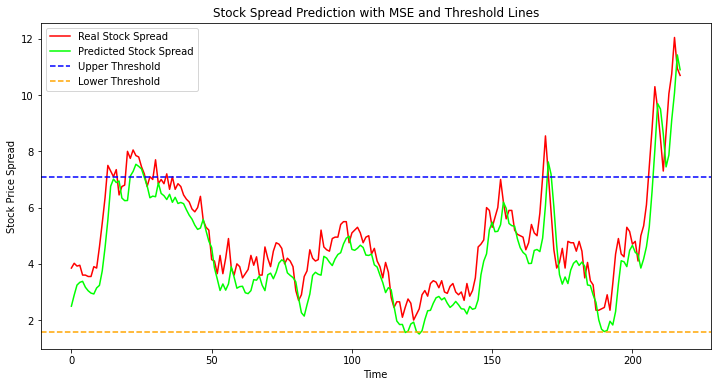

In [177]:
# Compute Mean Squared Error
mse = mean_squared_error(real_stock_spread, predicted_stock_spread)
print(f"Mean Squared Error: {mse}")

mean_spread = np.mean(predicted_stock_spread)
std_spread = np.std(predicted_stock_spread)
threshold = 1.5 * std_spread
print(f"Std: {std_spread}")

# Visualising the results with MSE and threshold lines
plt.figure(figsize=(12,6))
plt.plot(real_stock_spread, color='red', label='Real Stock Spread')
plt.plot(predicted_stock_spread, color='lime', label='Predicted Stock Spread')

# Draw horizontal lines for the threshold
plt.axhline(y=mean_spread + threshold, color='blue', linestyle='--', label='Upper Threshold')
plt.axhline(y=mean_spread - threshold, color='orange', linestyle='--', label='Lower Threshold')

# Draw a horizontal line for MSE
# plt.axhline(y=mse, color='purple', linestyle='-', label=f'MSE: {mse:.4f}')

plt.title('Stock Spread Prediction with MSE and Threshold Lines')
plt.xlabel('Time')
plt.ylabel('Stock Price Spread')
plt.legend()
plt.show()

In [178]:
# Convert the arrays to DataFrames
df_real_stock_spread_d = pd.DataFrame(real_stock_spread, columns=['Real Stock Spread'])
df_predicted_stock_spread_d = pd.DataFrame(predicted_stock_spread, columns=['Predicted Stock Spread'])

# Create DataFrames for stock codes and p-values
df_stock_codes_d = pd.DataFrame([[min_p_value_pair[0], min_p_value_pair[1]]], columns=['Stock Code 1', 'Stock Code 2'])
df_p_values_d = pd.DataFrame([[min_p_values[0], min_p_values[1]]], columns=['P-value 1', 'P-value 2'])

# Combine the DataFrames into a single DataFrame before saving
combined_df_d = pd.concat([df_real_stock_spread_d, df_predicted_stock_spread_d, df_stock_codes_d, df_p_values_d], axis=1)

# Save the combined DataFrame to an Excel file
combined_df_d.to_excel('defensive_stock_data_2012.xlsx', index=False)

In [179]:
# Assuming we have the same setup as previously defined
spreads = predicted_stock_spread  # Your spread data here
prices_overvalued, prices_undervalued, overvalued_code, undervalued_code = get_overvalued_and_undervalued_stocks(df, predicted_stock_spread, min_p_value_pair, const_year_test)

In [180]:
mean_spread = np.mean(spreads)
std_spread = np.std(spreads)
threshold = 1.5 * std_spread

# Track positions and other metrics
positions = []
profits = []
equity_curve = []
nominal_capital = 1  # Nominal capital at risk per trade
total_capital_invested = 0

total_shares_overvalued = 0
total_shares_undervalued = 0

for i, spread in enumerate(spreads):
    if (spread > mean_spread + threshold) or (spread < mean_spread - threshold):
        if i != len(spreads) - 1:
            # prices_overvalued, prices_undervalued, overvalued_code, undervalued_code = get_overvalued_and_undervalued_stocks(df, predicted_stock_spread, min_p_value_pair, const_year_test, i)
            # Enter trade
            num_shares_overvalued = nominal_capital / prices_overvalued[i] # 1 / prices_overvalued
            num_shares_undervalued = nominal_capital / prices_undervalued[i] # 1 / prices_undervalued
            if spread < 0:
                num_shares_overvalued = nominal_capital / prices_undervalued[i]
                num_shares_undervalued = nominal_capital / prices_overvalued[i]
            # debug
            print(f"Entering trade at index {i}, spread {spread}")
            print(f"Overvalued shares: {num_shares_overvalued}, Undervalued shares: {num_shares_undervalued}")
            total_shares_overvalued += num_shares_overvalued
            total_shares_undervalued += num_shares_undervalued
            total_capital_invested += (nominal_capital * 1.001425)
            positions.append(i)  # Store the index of the trading day
            check_enterOrNot = True
    if ((mean_spread - threshold <= spread <= mean_spread + threshold) and positions and check_enterOrNot == True) or (i == len(spreads) - 1 and positions and check_enterOrNot == True):
        # Exit trade
        exit_price_overvalued = prices_overvalued.iloc[-1]  # Last day price
        exit_price_undervalued = prices_undervalued.iloc[-1]  # Last day price
        pi = (total_shares_overvalued * exit_price_overvalued) - (total_shares_undervalued * exit_price_undervalued)
        pi = pi * (1 - 0.001425)
        profits.append(pi)
        positions.append(i)
        total_shares_overvalued = 0
        total_shares_undervalued = 0
        # debug
        print(f"Exiting trade at index {i}, spread {spread}")
        print(f"Profit from trade: {pi}")
        print("----------------END----------------")
        check_enterOrNot = False

        if i == len(spreads) - 1:  # If it's the last day, calculate the final equity curve point
            equity_curve.append(sum(profits) - total_capital_invested)


cumulative_profit = sum(profits)
total_trades = len(positions) # Total number of completed trades
total_capital_at_risk = total_trades * nominal_capital
return_rate = cumulative_profit / total_capital_at_risk if total_capital_at_risk != 0 else 0

print(f"Cumulative profit: {cumulative_profit}")
print(f"Total capital at risk: {total_capital_at_risk}")
print(f"Return rate: {return_rate * 100}%")

Entering trade at index 21, spread [7.1207314]
Overvalued shares: 0.05263157894736842, Undervalued shares: 0.08888888888888889
Entering trade at index 22, spread [7.2847266]
Overvalued shares: 0.052083333333333336, Undervalued shares: 0.08968609865470852
Entering trade at index 23, spread [7.5397696]
Overvalued shares: 0.05263157894736842, Undervalued shares: 0.08968609865470852
Entering trade at index 24, spread [7.465445]
Overvalued shares: 0.05235602094240837, Undervalued shares: 0.08849557522123894
Entering trade at index 25, spread [7.3734927]
Overvalued shares: 0.05361930294906166, Undervalued shares: 0.08928571428571429
Entering trade at index 26, spread [7.0771303]
Overvalued shares: 0.053475935828877004, Undervalued shares: 0.08695652173913043
Exiting trade at index 27, spread [6.775143]
Profit from trade: 0.7093302742770068
----------------END----------------
Entering trade at index 119, spread [1.5578068]
Overvalued shares: 0.06688963210702341, Undervalued shares: 0.08
Exiti